### TESTE 1

In [ ]:
# # 2. Normalizar os dados
# scaler = MinMaxScaler(feature_range=(0, 1))
# data_cleaned_month['val_geracao_scaled'] = scaler.fit_transform(data_cleaned_month[['val_geracao']])

# # 3. Preparar os dados para a LSTM
# def create_lstm_dataset(dataset, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-look_back):
#         a = dataset[i:(i+look_back), 0]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back, 0])
#     return np.array(dataX), np.array(dataY)

# look_back = 12  # Número de meses a serem usados como entrada para prever o próximo mês

# # Converter o DataFrame para um array
# dataset = data_cleaned_month['val_geracao_scaled'].values.reshape(-1, 1)

# # Criar o conjunto de dados para treinamento e teste
# train_size = int(len(dataset) * 0.8)
# train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# trainX, trainY = create_lstm_dataset(train, look_back)
# testX, testY = create_lstm_dataset(test, look_back)

# # 4. Reshape dos dados para o formato [amostras, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# # 5. Construir o modelo LSTM
# model = Sequential()
# model.add(LSTM(50, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')

# # 6. Treinar o modelo
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# # 7. Fazer previsões
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)

# # 8. Inverter a normalização para obter as previsões em escala original
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])

# # 9. Avaliação do modelo
# train_rmse = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
# test_rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))

# print(f"RMSE no conjunto de treinamento: {train_rmse}")
# print(f"RMSE no conjunto de teste: {test_rmse}")



In [ ]:
# plt.figure(figsize=(12, 6))
# plt.plot(data_cleaned_month.index[:len(trainPredict)], trainY[0], label='Real (Treinamento)', color='blue')
# plt.plot(data_cleaned_month.index[:len(trainPredict)], trainPredict[:, 0], label='Previsto (Treinamento)', color='orange', linestyle='dashed')
# plt.plot(data_cleaned_month.index[len(trainPredict):len(trainPredict) + len(testPredict)], testY[0], label='Real (Teste)', color='green')
# plt.plot(data_cleaned_month.index[len(trainPredict):len(trainPredict) + len(testPredict)], testPredict[:, 0], label='Previsto (Teste)', color='red', linestyle='dashed')
# plt.xlabel('Data')
# plt.ylabel('Produção de Energia (original scale)')
# plt.title('Previsões da Produção de Energia com LSTM')
# plt.legend()
# plt.show()

### TESTE 2

In [ ]:
def get_supervised_independent_var(series):
    return series.shift(1).fillna(0).values

# data_cleaned_month['X_shifted_geracao'] = get_supervised_independent_var(data_cleaned_month["val_geracao"])
# data_cleaned_month.head()

In [ ]:
def perform_diff(series):
    return pd.Series(series.diff().values)

# data_cleaned_month['diff_val_geracao'] = perform_diff(data_cleaned_month['val_geracao']).values

In [ ]:
# data_cleaned_month['diff_val_geracao'].plot(figsize=(16,7));

In [ ]:
# invert differenced value
def invert_diff_transform(initial_actual_item, diff_series):
    return np.r_[initial_actual_item, diff_series].cumsum()

# data_cleaned_month['invert_diff_geracao'] = invert_diff_transform(data_cleaned_month['val_geracao'].iloc[0], data_cleaned_month['diff_val_geracao'].iloc[1:])
# data_cleaned_month.head()

In [ ]:
# transform scale
def scale_transform(series):
    series = series.reshape(len(series), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(series)
    return  scaler, scaler.transform(series)

# scaler, data_cleaned_month['scaled_val_geracao'] = scale_transform(data_cleaned_month['val_geracao'].values)
# data_cleaned_month.head(5)

In [ ]:
# # Simply use 
# data_cleaned_month['inv_transformed_val_geracao'] = scaler.inverse_transform(data_cleaned_month['scaled_val_geracao'].values.reshape(-1, 1))
# data_cleaned_month.head()

In [ ]:
# Modelling function for same

# scale train and test data to [-1, 1]
def scale_transform(train, val, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)

    val = val.reshape(val.shape[0], val.shape[1])
    val_scaled = scaler.transform(val)

    return scaler, train_scaled, val_scaled, test_scaled


# invert transform
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [ ]:
def fit_lstm(train, batch_size, nb_epoch, neurons_l1):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons_l1, 
                   batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                   stateful=True))
    model.add(LSTM(neurons_l1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[early_stopping], validation_split=0.1)
        model.reset_states()

    return model

In [ ]:
def forecast(model, batch_size, row):
    x = row.reshape(1, 1, len(row))
    yhat = model.predict(x, batch_size=batch_size)
    return yhat[0,0]

In [ ]:
# preprocess dataset.
model_df = data_cleaned_month

# Transforming the data to a supervised learning problem.
diff_series = perform_diff(model_df.val_geracao).dropna()

# Transforming the data to be stationary.
X_series = get_supervised_independent_var(diff_series)
supervised_values = pd.DataFrame([X_series, diff_series.values]).T.values

train, test = supervised_values[:-24], supervised_values[-24:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale_transform(train, test)

# Fitting a stateful LSTM network model to the training data.
lstm_model = fit_lstm(train=train_scaled, batch_size=1, nb_epoch=80, neurons_l1=4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
# Evaluating the static LSTM model on the test data.
lstm_model.predict(train_reshaped, batch_size=1)
# # Report the performance of the forecasts.

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast: so that statefulness can help LSTM model to learn from previous forecast as well 
    X_row, y_row = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast(lstm_model, 1, X_row)
    # invert scaling
    
    yhat = invert_scale(scaler, X_row, yhat)

    # invert differencing
    yhat = yhat + model_df.val_geracao.values[-1]
    print(yhat)
    # store forecast
    predictions.append(yhat)
    expected = model_df.val_geracao[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

ValueError: Input 0 of layer "lstm_15" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (1, 4)

Test RMSE: 1851576.947


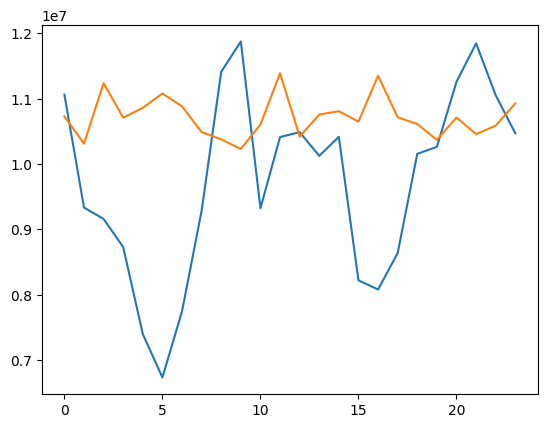

In [ ]:
# report performance
rmse = sqrt(mean_squared_error(model_df.val_geracao.values[-24:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(model_df.val_geracao.values[-24:])
plt.plot(predictions)
plt.show()

### TESTE 3

<Axes: >

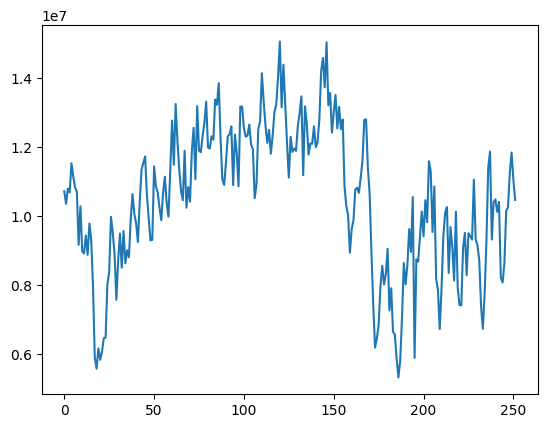

In [ ]:
temp = data_cleaned_month["val_geracao"]
temp.plot()

In [ ]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((247, 5, 1), (247,))

In [ ]:
X_train1, y_train1 = X1[:230], y1[:230]
X_val1, y_val1 = X1[230:240], y1[230:240]
X_test1, y_test1 = X1[240:], y1[240:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((230, 5, 1), (230,), (10, 5, 1), (10,), (7, 5, 1), (7,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError


In [ ]:
scaler, train_scaled, test_scaled = scale_transform(train, val, test)

In [ ]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1))

model1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                16896     
                                                                 
 dense_17 (Dense)            (None, 8)                 520       
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, callbacks=[cp1])

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [ ]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

8/8 [==============================] - 0s 2ms/step


,Train Predictions,Actuals
0,-0.49,11152054.60
1,-0.49,10837033.50
2,-0.49,10713982.40
3,-0.49,9167134.18
4,-0.49,10284573.00
...,...,...
225,-0.49,9156961.87
226,-0.49,8726184.24
227,-0.49,7393989.09
228,-0.49,6730046.81


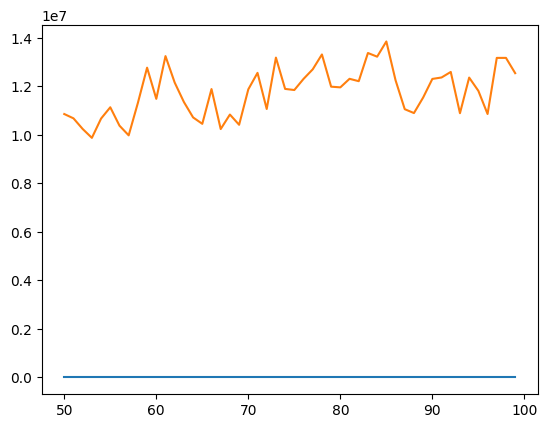

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [ ]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

In [ ]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [ ]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

In [ ]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

### TESTE 4

In [ ]:
temp = data_cleaned_month

<Axes: >

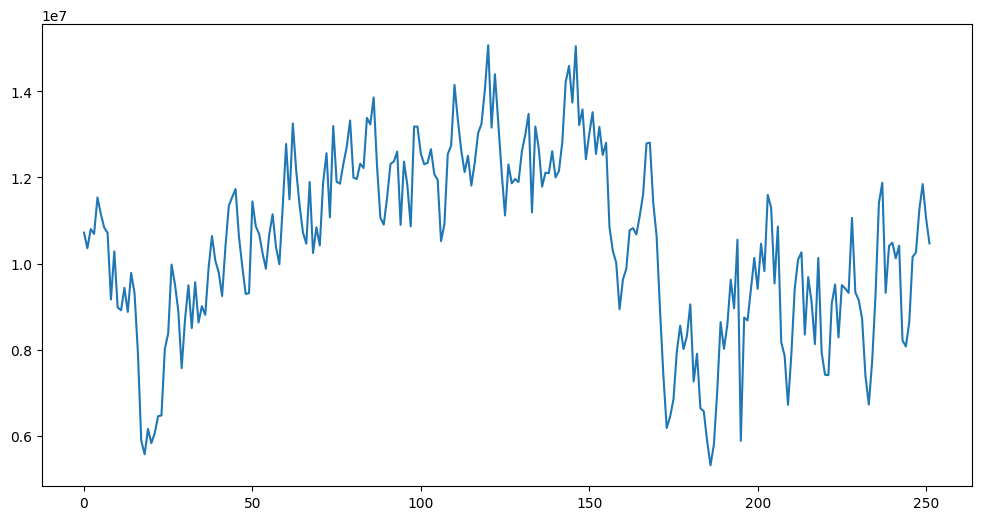

In [ ]:
temp['val_geracao'].plot(figsize=(12, 6))

In [ ]:
temp.head()

,ano-mes,val_geracao,ano,mes
0,2000-01,10719179.70,2000,1
1,2000-02,10356806.30,2000,2
2,2000-03,10800055.29,2000,3
3,2000-04,10688398.50,2000,4
4,2000-05,11534436.10,2000,5


In [ ]:
train = temp.iloc[:240]
test = temp.iloc[240:]

In [ ]:
train.shape, test.shape

((240, 4), (12, 4))

In [ ]:
scaler = MinMaxScaler()

In [ ]:
temp.head(),temp.tail()

(   ano-mes  val_geracao   ano  mes
 0  2000-01  10719179.70  2000    1
 1  2000-02  10356806.30  2000    2
 2  2000-03  10800055.29  2000    3
 3  2000-04  10688398.50  2000    4
 4  2000-05  11534436.10  2000    5,
      ano-mes  val_geracao   ano  mes
 247  2020-08  10260306.43  2020    8
 248  2020-09  11255679.29  2020    9
 249  2020-10  11845207.08  2020   10
 250  2020-11  11050187.94  2020   11
 251  2020-12  10468392.94  2020   12)

In [ ]:
scaler.fit(train['val_geracao'].values.reshape(-1, 1))
scaled_train = scaler.transform(train['val_geracao'].values.reshape(-1, 1))
scaled_test = scaler.transform(test['val_geracao'].values.reshape(-1, 1))

In [ ]:
scaled_train.shape, scaled_test.shape

((240, 1), (12, 1))

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint

In [ ]:
n_features = 1
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

cp1 = ModelCheckpoint('model1/', save_best_only=True)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
# model.compile(loss='mse', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 100)               40800     
                                                                 
 dropout_23 (Dropout)        (None, 100)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                6464      
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 49377 (192.88 KB)
Trainable params: 493

In [ ]:
# fit model

model.fit(generator,epochs=50)

Epoch 1/50


228/228 [==============================] - 2s 3ms/step - loss: 0.2342 - root_mean_squared_error: 0.4839
Epoch 2/50
228/228 [==============================] - 1s 3ms/step - loss: 0.0363 - root_mean_squared_error: 0.1906
Epoch 3/50
228/228 [==============================] - 1s 3ms/step - loss: 0.0316 - root_mean_squared_error: 0.1777
Epoch 4/50
228/228 [==============================] - 1s 3ms/step - loss: 0.0287 - root_mean_squared_error: 0.1693
Epoch 5/50
228/228 [==============================] - 1s 3ms/step - loss: 0.0295 - root_mean_squared_error: 0.1716
Epoch 6/50
228/228 [==============================] - 1s 3ms/step - loss: 0.0290 - root_mean_squared_error: 0.1703
Epoch 7/50
228/228 [==============================] - 1s 3ms/step - loss: 0.0265 - root_mean_squared_error: 0.1629
Epoch 8/50
228/228 [==============================] - 1s 3ms/step - loss: 0.0268 - root_mean_squared_error: 0.1637
Epoch 9/50
228/228 [==============================] - 1s 3ms/step - loss: 0.0263 - root_mea

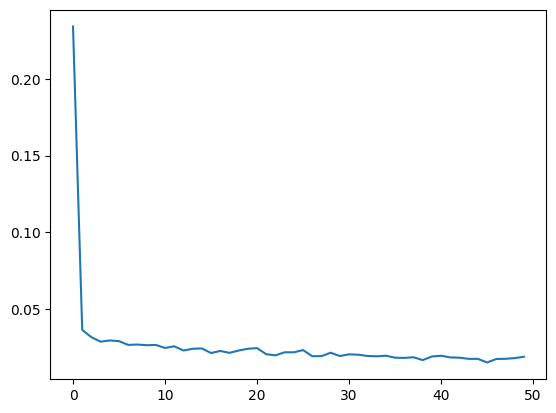

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 14ms/step


In [ ]:
test_predictions

[array([0.48147425], dtype=float32),
 array([0.47630677], dtype=float32),
 array([0.4733657], dtype=float32),
 array([0.47079793], dtype=float32),
 array([0.46862277], dtype=float32),
 array([0.46700662], dtype=float32),
 array([0.4654282], dtype=float32),
 array([0.46391708], dtype=float32),
 array([0.4621533], dtype=float32),
 array([0.45959434], dtype=float32),
 array([0.45708224], dtype=float32),
 array([0.45515445], dtype=float32)]

In [ ]:
test.head(12)

,ano-mes,val_geracao,ano,mes,Predictions
240,2020-01,10485916.57,2020,1,10172876.13
241,2020-02,10123038.49,2020,2,10136824.64
242,2020-03,10414208.90,2020,3,10097596.42
243,2020-04,8216977.27,2020,4,10026011.87
244,2020-05,8077386.46,2020,5,9804866.41
245,2020-06,8634235.08,2020,6,9579870.42
246,2020-07,10154333.57,2020,7,9575929.57
247,2020-08,10260306.43,2020,8,9748868.13
248,2020-09,11255679.29,2020,9,10139931.67
249,2020-10,11845207.08,2020,10,10441711.80


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

C:\Users\gabri\AppData\Local\Temp\ipykernel_16316\4269337381.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
test.head()

,ano-mes,val_geracao,ano,mes,Predictions
240,2020-01,10485916.57,2020,1,10172876.13
241,2020-02,10123038.49,2020,2,10136824.64
242,2020-03,10414208.90,2020,3,10097596.42
243,2020-04,8216977.27,2020,4,10026011.87
244,2020-05,8077386.46,2020,5,9804866.41


<Axes: >

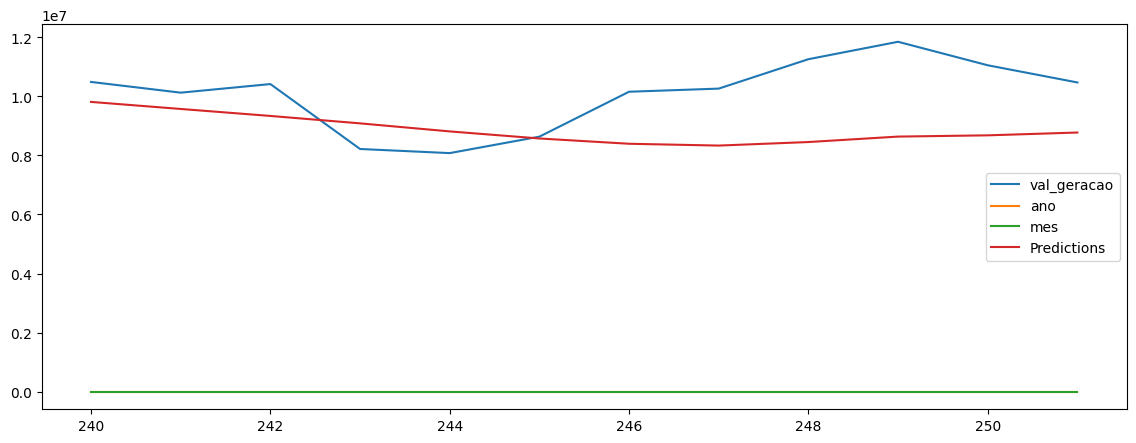

In [ ]:
test.plot(figsize=(14,5))

In [ ]:
def avaliando_modelo(train_y, test_y, train_predict, test_predict):
    train_rmse = np.sqrt(keras.losses.mean_squared_error(train_y.flatten(), train_predict.flatten()))
    # Convertendo RMSE para termos percentuais
    train_rmse_percent = (train_rmse / np.mean(train_y.flatten())) * 100
    print('Train Score: %.2f%% RMSE' % train_rmse_percent)

    test_rmse = np.sqrt(keras.losses.mean_squared_error(test_y.flatten(), test_predict.flatten()))
    # Convertendo RMSE para termos percentuais
    test_rmse_percent = (test_rmse / np.mean(test_y.flatten())) * 100
    print('Test Score: %.2f%% RMSE\n' % test_rmse_percent)

    trainScore = (keras.losses.mean_absolute_percentage_error(train_y.flatten(), train_predict.flatten()))
    print('Train Score: %.2f%% MAPE' % (trainScore))
    testScore = (keras.losses.mean_absolute_percentage_error(test_y.flatten() , test_predict.flatten()))
    print('Test Score: %.2f%% MAPE' % (testScore))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['val_geracao'],test['Predictions']))
print(rmse)

984259.8656668379


### TESTE 5

# <font color='red'> 4) Modelo de predição</font>

In [ ]:
import keras
import tensorflow as tf

from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM 
from keras.layers import Dropout 
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler


from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
temp = data_cleaned_month['val_geracao'].values 

### 4.1) Divisão dos dados: os ultimo 24 meses correspondentes aos anos de 2019 e 2020

In [ ]:
train_size = len(temp) - 24
test_size = 24
print("Train Size :",train_size,"Test Size :",test_size)

train_data = temp[:228]
test_data = temp[228:]

Train Size : 228 Test Size : 24


### 4.2) Pré-processamento dos dados: Normalizando dados numa escala entre 0 e 1

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
train_data_scaled = scaler.fit_transform(train_data.reshape(-1,1))
test_data_scaled = scaler.transform(test_data.reshape(-1,1))

In [ ]:
train_data_scaled.shape

(228, 1)

In [ ]:
test_data_scaled.shape

(24, 1)

### 4.3) Preparando séries temporais

In [ ]:
time_stemp = 12

generator = TimeseriesGenerator(train_data_scaled, train_data_scaled, length=time_stemp, batch_size=1)

In [ ]:
def prepare_sequences(data, time_stemp):
    data_X, data_y = [], []
    for i in range(len(data) - time_stemp):
        data_X.append(data[i:(i + time_stemp)])
        data_y.append(data[i + time_stemp])
    
    data_X, data_y = np.array(data_X), np.array(data_y)

    data_X = np.reshape(data_X, (data_X.shape[0], data_X.shape[1], 1))
    return data_X, data_y

In [ ]:
time_stemp = 12

train_X, train_y = prepare_sequences(train_data_scaled, time_stemp)
test_X, test_y = prepare_sequences(test_data_scaled, time_stemp)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

### 4.4) Arquitetando rede neural recorrente (LSTM)

In [ ]:
# print(train_X.shape[1])

In [ ]:
def create_lstm_model(time_stemp: int):
    model = Sequential()
    model.add(LSTM(units=50, activation="relu", return_sequences=True, input_shape=(time_stemp, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer="adam" )
    return model

In [ ]:
model = create_lstm_model(time_stemp)

model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 12, 50)            10400     
                                                                 
 dropout_63 (Dropout)        (None, 12, 50)            0         
                                                                 
 lstm_60 (LSTM)              (None, 50)                20200     
                                                                 
 dense_88 (Dense)            (None, 64)                3264      
                                                                 
 dense_89 (Dense)            (None, 32)                2080      
                                                                 
 dropout_64 (Dropout)        (None, 32)                0         
                                                                 
 dense_90 (Dense)            (None, 1)               

In [ ]:
epochs = 100

history = model.fit(generator, epochs = epochs, batch_size = 50, verbose=1)

Epoch 1/100


216/216 [==============================] - 1s 4ms/step - loss: 0.0156
Epoch 2/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0154
Epoch 3/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0140
Epoch 4/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0155
Epoch 5/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0158
Epoch 6/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0157
Epoch 7/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0161
Epoch 8/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0156
Epoch 9/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0138
Epoch 10/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0141
Epoch 11/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0139
Epoch 12/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0139
Epoch 13/100
216/216 [===

In [ ]:
epoch = np.arange(0, epochs, 10)
losses = []
for i in epoch:
    if i % 10 == 0:
        losses.append(history.history["loss"][i])
        
data = {"epoch":epoch,"loss":losses}
data = pd.DataFrame(data) 

fig = px.line(data,x="epoch",y="loss",width = 1200, height = 500)
fig.show()

# <font color='red'> 5) Avaliação do modelo</font>

### 5.1) Predição dos dados de treino e teste

In [ ]:
def data_prediction(model, train_X, test_X, train_y, test_y):
    train_predict = model.predict(train_X)
    test_predict = model.predict(test_X)

    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    train_y = np.reshape(train_y, (-1, 1))
    test_y = np.reshape(test_y, (-1, 1))

    train_y = scaler.inverse_transform(train_y)
    test_y = scaler.inverse_transform(test_y)

    return train_predict, test_predict, train_y, test_y

In [ ]:
train_predict, test_predict, train_y, test_y = data_prediction(model, train_X, test_X, train_y, test_y)

1/1 [==============================] - 0s 14ms/step


### 5.2) Erro Percentual Absoluto Médio

In [ ]:
def avaliando_modelo(train_y, test_y, train_predict, test_predict):
    train_rmse = np.sqrt(keras.losses.mean_squared_error(train_y.flatten(), train_predict.flatten()))
    # Convertendo RMSE para termos percentuais
    train_rmse_percent = (train_rmse / np.mean(train_y.flatten())) * 100
    print('Train Score: %.2f%% RMSE' % train_rmse_percent)

    test_rmse = np.sqrt(keras.losses.mean_squared_error(test_y.flatten(), test_predict.flatten()))
    # Convertendo RMSE para termos percentuais
    test_rmse_percent = (test_rmse / np.mean(test_y.flatten())) * 100
    print('Test Score: %.2f%% RMSE\n' % test_rmse_percent)

    trainScore = (keras.losses.mean_absolute_percentage_error(train_y.flatten(), train_predict.flatten()))
    print('Train Score: %.2f%% MAPE' % (trainScore))
    testScore = (keras.losses.mean_absolute_percentage_error(test_y.flatten() , test_predict.flatten()))
    print('Test Score: %.2f%% MAPE' % (testScore))

In [ ]:
avaliando_modelo(train_y, test_y, train_predict, test_predict)

Train Score: 10.38% RMSE
Test Score: 12.46% RMSE

Train Score: 8.90% MAPE
Test Score: 10.50% MAPE


### 5.3) Plotando gráfico de predição 

ValueError: x and y must have same first dimension, but have shapes (216,) and (1,)

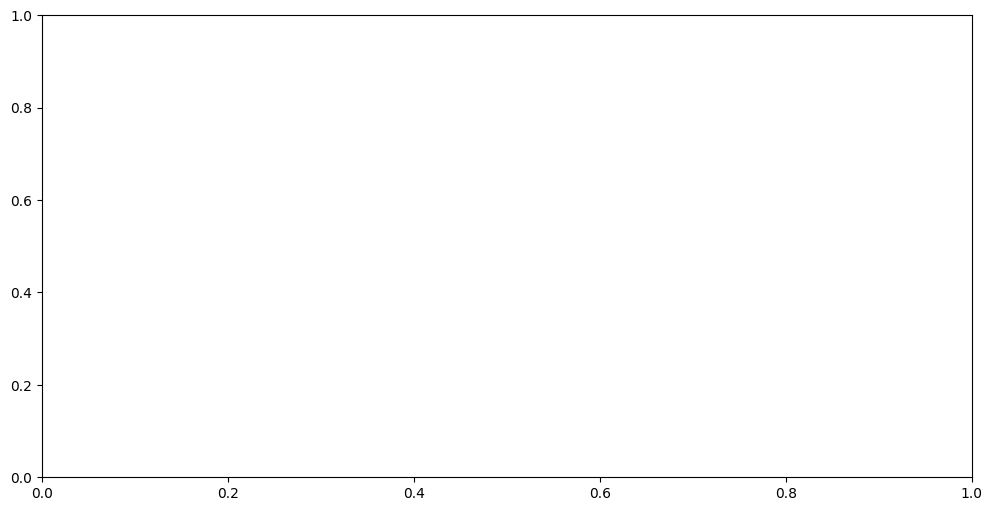

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data_cleaned_month.index[:len(train_predict)], train_y[0], label='Real (Treinamento)', color='blue')
plt.plot(data_cleaned_month.index[:len(train_predict)], train_predict[:, 0], label='Previsto (Treinamento)', color='orange', linestyle='dashed')
# plt.plot(output_data.index[len(train_predict):len(train_predict) + len(test_predict)], test_y[0], label='Real (Teste)', color='green')
# plt.plot(output_data.index[len(train_predict):len(train_predict) + len(test_predict)], test_predict[:, 0], label='Previsto (Teste)', color='red', linestyle='dashed')
plt.xlabel('Data')
plt.ylabel('Produção de Energia (original scale)')
plt.title('Previsões da Produção de Energia com LSTM')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (23,) and (1,)

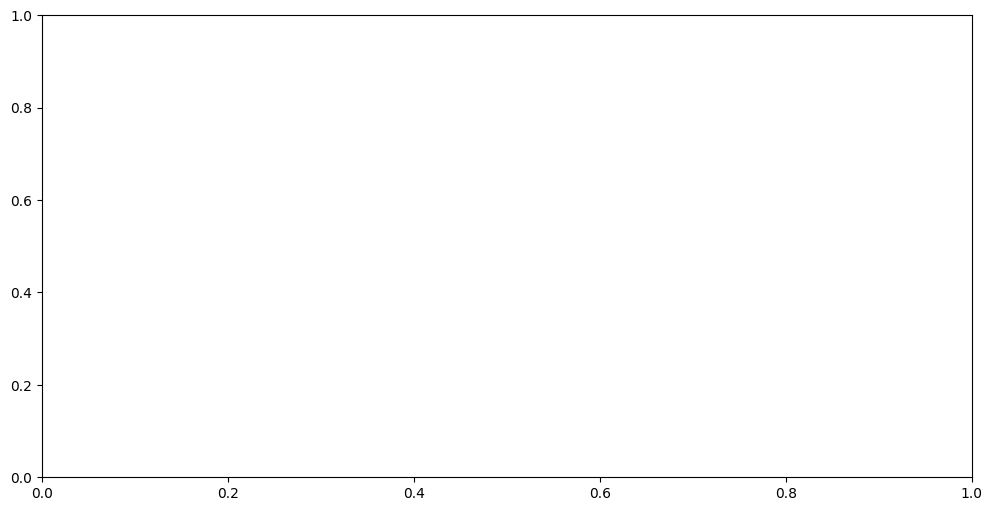

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(output_data.index[:len(train_predict)], train_y[0], label='Real (Treinamento)', color='blue')
# plt.plot(output_data.index[:len(train_predict)], train_predict[:, 0], label='Previsto (Treinamento)', color='orange', linestyle='dashed')
plt.plot(data_cleaned_month.index[len(train_predict):len(train_predict) + len(test_predict)], test_y[0], label='Real (Teste)', color='green')
plt.plot(data_cleaned_month.index[len(train_predict):len(train_predict) + len(test_predict)], test_predict[:, 0], label='Previsto (Teste)', color='red', linestyle='dashed')
plt.xlabel('Data')
plt.ylabel('Produção de Energia (original scale)')
plt.title('Previsões da Produção de Energia com LSTM')
plt.legend()
plt.show()

In [ ]:
train_predict_plot = np.empty_like(temp)
train_predict_plot[:,:] = np.nan
train_predict_plot[time_stemp:len(train_predict) + time_stemp, :] = train_predict

test_predict_plot = np.empty_like(temp)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_stemp * 2):len(temp) - 2, :] = test_predict


plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(temp),color = "red",label = "Real")
plt.plot(train_predict_plot,label = "Predição treinamento",color = "green", alpha = 0.7)
plt.plot(test_predict_plot,label = "Predição teste",color = "blue", alpha = 0.7)
plt.legend()
plt.xlabel("Tempo (em meses)")
plt.ylabel("Valor de Geração (em milhões MWmed)")
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### 5.4) Comparando os resultados com os reais

### 5.4.1) Ano 2019

In [ ]:
test_y.shape

(12, 1)

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

test_y_flatten = test_y.flatten()[:12]
test_predict_flatten = test_predict.flatten()[:12]

# Calculating the percentage difference
percentage_difference = abs(((test_y_flatten - test_predict_flatten) / test_y_flatten) * 100)

# Creating a DataFrame for comparison
comparacao_df = pd.DataFrame({'Real': test_y_flatten, 'Predito': test_predict_flatten, 'Diferença (%)': percentage_difference})

total_percentage_difference = abs(((test_y_flatten.sum() - test_predict_flatten.sum()) / test_y_flatten.sum()) * 100)

# Adding a row for the total
total_row = pd.DataFrame({'Real': test_y_flatten.sum(), 'Predito': test_predict_flatten.sum(), 'Diferença (%)': total_percentage_difference}, index=[len(comparacao_df)])
comparacao_df = pd.concat([comparacao_df, total_row])

display(comparacao_df)

,Real,Predito,Diferença (%)
0,10485916.57,9692181.00,7.57
1,10123038.49,9876241.00,2.44
2,10414208.90,9929211.00,4.66
3,8216977.27,10023286.00,21.98
4,8077386.46,9409581.00,16.49
5,8634235.08,8747205.00,1.31
6,10154333.57,8482643.00,16.46
7,10260306.43,8880083.00,13.45
8,11255679.29,9337870.00,17.04
9,11845207.08,9839484.00,16.93


### 5.4.2) Ano 2020

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

test_y_flatten = test_y.flatten()[-12:]
test_predict_flatten = test_predict.flatten()[-12:]

# Calculating the percentage difference
percentage_difference = abs(((test_y_flatten - test_predict_flatten) / test_y_flatten) * 100)

# Creating a DataFrame for comparison
comparacao_df = pd.DataFrame({'Real': test_y_flatten, 'Predito': test_predict_flatten, 'Diferença (%)': percentage_difference})

total_percentage_difference = abs(((test_y_flatten.sum() - test_predict_flatten.sum()) / test_y_flatten.sum()) * 100)

# Adding a row for the total
total_row = pd.DataFrame({'Real': test_y_flatten.sum(), 'Predito': test_predict_flatten.sum(), 'Diferença (%)': total_percentage_difference}, index=[len(comparacao_df)])
comparacao_df = pd.concat([comparacao_df, total_row])

display(comparacao_df)

,Real,Predito,Diferença (%)
0,10485916.57,9692181.00,7.57
1,10123038.49,9876241.00,2.44
2,10414208.90,9929211.00,4.66
3,8216977.27,10023286.00,21.98
4,8077386.46,9409581.00,16.49
5,8634235.08,8747205.00,1.31
6,10154333.57,8482643.00,16.46
7,10260306.43,8880083.00,13.45
8,11255679.29,9337870.00,17.04
9,11845207.08,9839484.00,16.93


### TESTE 6

# <font color='red'> 4) Modelo de predição</font>

In [ ]:
import keras
import tensorflow as tf

from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM 
from keras.layers import Dropout 
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler


from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
temp = data_cleaned_month['val_geracao'].values 

### 4.1) Divisão dos dados: os ultimo 24 meses correspondentes aos anos de 2019 e 2020

In [ ]:
train_size = len(temp) - 24
test_size = 24
print("Train Size :",train_size,"Test Size :",test_size)

train_data = temp[:228]
test_data = temp[228:]

Train Size : 228 Test Size : 24


### 4.2) Pré-processamento dos dados: Normalizando dados numa escala entre 0 e 1

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
train_data_scaled = scaler.fit_transform(train_data.reshape(-1,1))
test_data_scaled = scaler.transform(test_data.reshape(-1,1))

In [ ]:
train_data_scaled.shape

(228, 1)

In [ ]:
test_data_scaled.shape

(24, 1)

### 4.3) Preparando séries temporais

In [ ]:
time_stemp = 12
n_features = 1

generator = TimeseriesGenerator(train_data_scaled, train_data_scaled, length=time_stemp, batch_size=1)

In [ ]:
generator[1]

(array([[[0.51678708],
         [0.56227069],
         [0.55081313],
         [0.63762855],
         [0.5983908 ],
         [0.56606518],
         [0.5534384 ],
         [0.3947099 ],
         [0.50937492],
         [0.37576354],
         [0.36916227],
         [0.42256097]]]),
 array([[0.3651552]]))

### 4.4) Arquitetando rede neural recorrente (LSTM)

In [ ]:
# print(train_X.shape[1])

In [ ]:
def create_lstm_model(time_stemp: int, n_features: int):
    model = Sequential()
    model.add(LSTM(units=50, activation="relu", return_sequences=True, input_shape=(time_stemp, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer="adam" )
    return model

In [ ]:
model = create_lstm_model(time_stemp, n_features)

model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 12, 50)            10400     
                                                                 
 dropout_65 (Dropout)        (None, 12, 50)            0         
                                                                 
 lstm_62 (LSTM)              (None, 50)                20200     
                                                                 
 dense_91 (Dense)            (None, 64)                3264      
                                                                 
 dense_92 (Dense)            (None, 32)                2080      
                                                                 
 dropout_66 (Dropout)        (None, 32)                0         
                                                                 
 dense_93 (Dense)            (None, 1)               

In [ ]:
epochs = 100

history = model.fit(generator, epochs = epochs, batch_size = 50, verbose=1)

Epoch 1/100


216/216 [==============================] - 3s 4ms/step - loss: 0.0489
Epoch 2/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0347
Epoch 3/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0319
Epoch 4/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0258
Epoch 5/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0266
Epoch 6/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0231
Epoch 7/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0222
Epoch 8/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0213
Epoch 9/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0254
Epoch 10/100
216/216 [==============================] - 1s 5ms/step - loss: 0.0232
Epoch 11/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0209
Epoch 12/100
216/216 [==============================] - 1s 4ms/step - loss: 0.0202
Epoch 13/100
216/216 [===

In [ ]:
epoch = np.arange(0, epochs, 10)
losses = []
for i in epoch:
    if i % 10 == 0:
        losses.append(history.history["loss"][i])
        
data = {"epoch":epoch,"loss":losses}
data = pd.DataFrame(data) 

fig = px.line(data,x="epoch",y="loss",width = 1200, height = 500)
fig.show()

# <font color='red'> 5) Avaliação do modelo</font>

In [ ]:
test_predictions = []

first_eval_batch = train_data_scaled[-time_stemp:]
current_batch = first_eval_batch.reshape((1, time_stemp, n_features))

for i in range(len(test_data)):
    
    print("{} mês input {}".format(i + 1, current_batch))
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch, verbose=0)[0]

    print("{} mês output {}\n".format(i + 1, current_pred))
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1 mês input [[[0.3892355 ]
  [0.28845758]
  [0.49353152]
  [0.26805051]
  [0.2154394 ]
  [0.21461659]
  [0.38546403]
  [0.43056318]
  [0.30435623]
  [0.42914623]
  [0.42075116]
  [0.41038031]]]
1 mês output [0.41526264]

2 mês input [[[0.28845758]
  [0.49353152]
  [0.26805051]
  [0.2154394 ]
  [0.21461659]
  [0.38546403]
  [0.43056318]
  [0.30435623]
  [0.42914623]
  [0.42075116]
  [0.41038031]
  [0.41526264]]]
2 mês output [0.41329947]

3 mês input [[[0.49353152]
  [0.26805051]
  [0.2154394 ]
  [0.21461659]
  [0.38546403]
  [0.43056318]
  [0.30435623]
  [0.42914623]
  [0.42075116]
  [0.41038031]
  [0.41526264]
  [0.41329947]]]
3 mês output [0.42403838]

4 mês input [[[0.26805051]
  [0.2154394 ]
  [0.21461659]
  [0.38546403]
  [0.43056318]
  [0.30435623]
  [0.42914623]
  [0.42075116]
  [0.41038031]
  [0.41526264]
  [0.41329947]
  [0.42403838]]]
4 mês output [0.41094786]

5 mês input [[[0.2154394 ]
  [0.21461659]
  [0.38546403]
  [0.43056318]
  [0.30435623]
  [0.42914623]
  [0.42075116]

In [ ]:
test_predictions

[array([0.41526264], dtype=float32),
 array([0.41329947], dtype=float32),
 array([0.42403838], dtype=float32),
 array([0.41094786], dtype=float32),
 array([0.413768], dtype=float32),
 array([0.4303104], dtype=float32),
 array([0.46890447], dtype=float32),
 array([0.4894132], dtype=float32),
 array([0.4881156], dtype=float32),
 array([0.49728906], dtype=float32),
 array([0.49893174], dtype=float32),
 array([0.5017925], dtype=float32),
 array([0.5038362], dtype=float32),
 array([0.5065697], dtype=float32),
 array([0.51183474], dtype=float32),
 array([0.5231081], dtype=float32),
 array([0.53849643], dtype=float32),
 array([0.553079], dtype=float32),
 array([0.5681547], dtype=float32),
 array([0.58031005], dtype=float32),
 array([0.5897996], dtype=float32),
 array([0.59805745], dtype=float32),
 array([0.6055824], dtype=float32),
 array([0.6137308], dtype=float32)]

### 5.1) Predição dos dados de treino e teste

### 5.2) Erro Percentual Absoluto Médio

In [ ]:
def avaliando_modelo(train_y, test_y, train_predict, test_predict):
    train_rmse = np.sqrt(keras.losses.mean_squared_error(train_y.flatten(), train_predict.flatten()))
    # Convertendo RMSE para termos percentuais
    train_rmse_percent = (train_rmse / np.mean(train_y.flatten())) * 100
    print('Train Score: %.2f%% RMSE' % train_rmse_percent)

    test_rmse = np.sqrt(keras.losses.mean_squared_error(test_y.flatten(), test_predict.flatten()))
    # Convertendo RMSE para termos percentuais
    test_rmse_percent = (test_rmse / np.mean(test_y.flatten())) * 100
    print('Test Score: %.2f%% RMSE\n' % test_rmse_percent)

    trainScore = (keras.losses.mean_absolute_percentage_error(train_y.flatten(), train_predict.flatten()))
    print('Train Score: %.2f%% MAPE' % (trainScore))
    testScore = (keras.losses.mean_absolute_percentage_error(test_y.flatten() , test_predict.flatten()))
    print('Test Score: %.2f%% MAPE' % (testScore))

In [ ]:
avaliando_modelo(train_y, test_y, train_predict, test_predict)

Train Score: 10.38% RMSE
Test Score: 12.46% RMSE

Train Score: 8.90% MAPE
Test Score: 10.50% MAPE


### 5.3) Plotando gráfico de predição 

ValueError: x and y must have same first dimension, but have shapes (216,) and (1,)

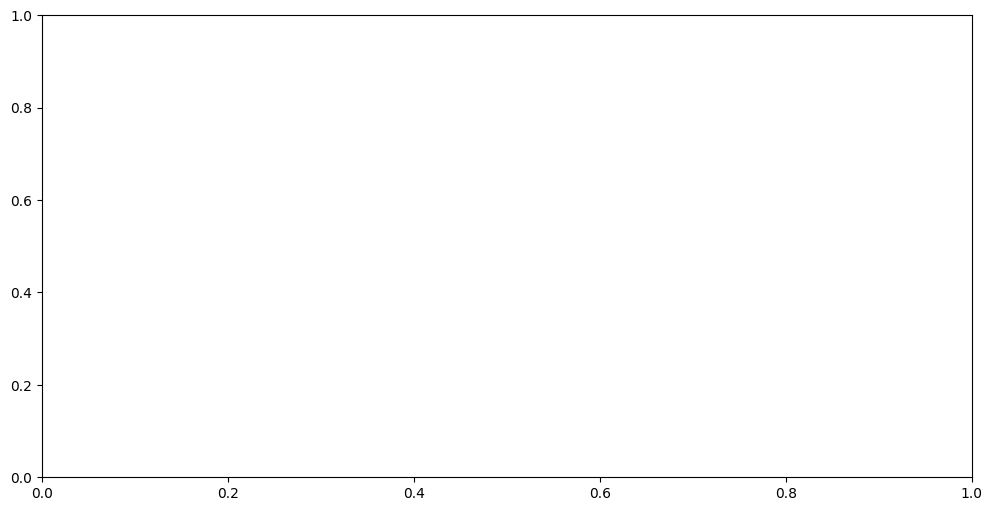

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data_cleaned_month.index[:len(train_predict)], train_y[0], label='Real (Treinamento)', color='blue')
plt.plot(data_cleaned_month.index[:len(train_predict)], train_predict[:, 0], label='Previsto (Treinamento)', color='orange', linestyle='dashed')
# plt.plot(output_data.index[len(train_predict):len(train_predict) + len(test_predict)], test_y[0], label='Real (Teste)', color='green')
# plt.plot(output_data.index[len(train_predict):len(train_predict) + len(test_predict)], test_predict[:, 0], label='Previsto (Teste)', color='red', linestyle='dashed')
plt.xlabel('Data')
plt.ylabel('Produção de Energia (original scale)')
plt.title('Previsões da Produção de Energia com LSTM')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (23,) and (1,)

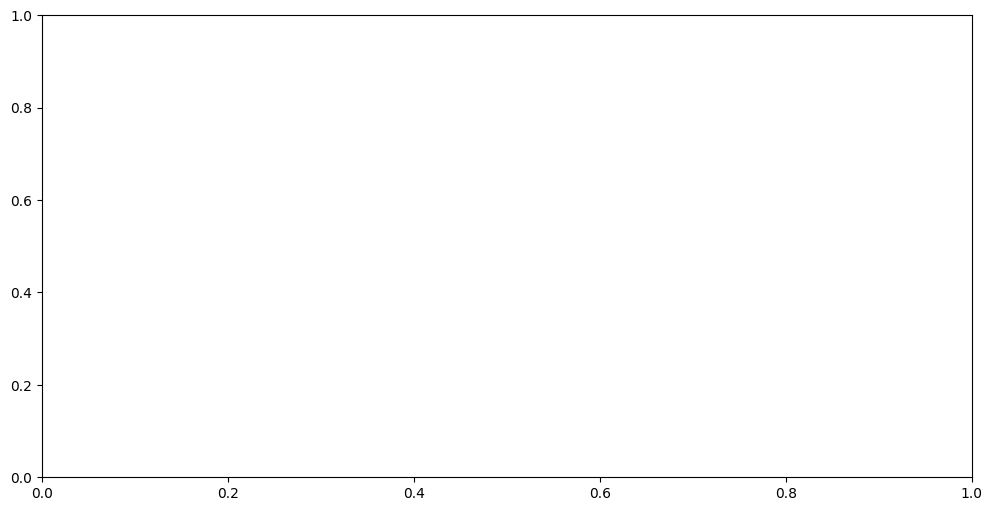

In [ ]:
plt.figure(figsize=(12, 6))
# plt.plot(output_data.index[:len(train_predict)], train_y[0], label='Real (Treinamento)', color='blue')
# plt.plot(output_data.index[:len(train_predict)], train_predict[:, 0], label='Previsto (Treinamento)', color='orange', linestyle='dashed')
plt.plot(data_cleaned_month.index[len(train_predict):len(train_predict) + len(test_predict)], test_y[0], label='Real (Teste)', color='green')
plt.plot(data_cleaned_month.index[len(train_predict):len(train_predict) + len(test_predict)], test_predict[:, 0], label='Previsto (Teste)', color='red', linestyle='dashed')
plt.xlabel('Data')
plt.ylabel('Produção de Energia (original scale)')
plt.title('Previsões da Produção de Energia com LSTM')
plt.legend()
plt.show()

In [ ]:
train_predict_plot = np.empty_like(temp)
train_predict_plot[:,:] = np.nan
train_predict_plot[time_stemp:len(train_predict) + time_stemp, :] = train_predict

test_predict_plot = np.empty_like(temp)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_stemp * 2):len(temp) - 2, :] = test_predict


plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(temp),color = "red",label = "Real")
plt.plot(train_predict_plot,label = "Predição treinamento",color = "green", alpha = 0.7)
plt.plot(test_predict_plot,label = "Predição teste",color = "blue", alpha = 0.7)
plt.legend()
plt.xlabel("Tempo (em meses)")
plt.ylabel("Valor de Geração (em milhões MWmed)")
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### 5.4) Comparando os resultados com os reais

### 5.4.1) Ano 2019

In [ ]:
test_y.shape

(12, 1)

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

test_y_flatten = test_y.flatten()[:12]
test_predict_flatten = test_predict.flatten()[:12]

# Calculating the percentage difference
percentage_difference = abs(((test_y_flatten - test_predict_flatten) / test_y_flatten) * 100)

# Creating a DataFrame for comparison
comparacao_df = pd.DataFrame({'Real': test_y_flatten, 'Predito': test_predict_flatten, 'Diferença (%)': percentage_difference})

total_percentage_difference = abs(((test_y_flatten.sum() - test_predict_flatten.sum()) / test_y_flatten.sum()) * 100)

# Adding a row for the total
total_row = pd.DataFrame({'Real': test_y_flatten.sum(), 'Predito': test_predict_flatten.sum(), 'Diferença (%)': total_percentage_difference}, index=[len(comparacao_df)])
comparacao_df = pd.concat([comparacao_df, total_row])

display(comparacao_df)

,Real,Predito,Diferença (%)
0,10485916.57,9692181.00,7.57
1,10123038.49,9876241.00,2.44
2,10414208.90,9929211.00,4.66
3,8216977.27,10023286.00,21.98
4,8077386.46,9409581.00,16.49
5,8634235.08,8747205.00,1.31
6,10154333.57,8482643.00,16.46
7,10260306.43,8880083.00,13.45
8,11255679.29,9337870.00,17.04
9,11845207.08,9839484.00,16.93


### 5.4.2) Ano 2020

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

test_y_flatten = test_y.flatten()[-12:]
test_predict_flatten = test_predict.flatten()[-12:]

# Calculating the percentage difference
percentage_difference = abs(((test_y_flatten - test_predict_flatten) / test_y_flatten) * 100)

# Creating a DataFrame for comparison
comparacao_df = pd.DataFrame({'Real': test_y_flatten, 'Predito': test_predict_flatten, 'Diferença (%)': percentage_difference})

total_percentage_difference = abs(((test_y_flatten.sum() - test_predict_flatten.sum()) / test_y_flatten.sum()) * 100)

# Adding a row for the total
total_row = pd.DataFrame({'Real': test_y_flatten.sum(), 'Predito': test_predict_flatten.sum(), 'Diferença (%)': total_percentage_difference}, index=[len(comparacao_df)])
comparacao_df = pd.concat([comparacao_df, total_row])

display(comparacao_df)

,Real,Predito,Diferença (%)
0,10485916.57,9692181.00,7.57
1,10123038.49,9876241.00,2.44
2,10414208.90,9929211.00,4.66
3,8216977.27,10023286.00,21.98
4,8077386.46,9409581.00,16.49
5,8634235.08,8747205.00,1.31
6,10154333.57,8482643.00,16.46
7,10260306.43,8880083.00,13.45
8,11255679.29,9337870.00,17.04
9,11845207.08,9839484.00,16.93


### EXTRA - Usando PyCaret 

In [ ]:
data = data_cleaned_month

data

In [ ]:
# Convertendo o índice de data para string
data.index = data.index.astype(str)

# Calcular a média móvel de 12 meses
data['MA12'] = data['val_geracao'].rolling(12).mean()

# Plotar o gráfico
fig = px.line(data, x=data.index, y=["val_geracao", "MA12"], template='plotly_dark')
fig.show()

In [ ]:
data['Series'] = np.arange(1,len(data)+1)

data.drop(['ano-mes', 'MA12'], axis=1, inplace=True)

data = data[['Series', 'ano', 'mes', 'val_geracao']] 

data.head()

,Series,ano,mes,val_geracao
0,1,2000,1,10719179.70
1,2,2000,2,10356806.30
2,3,2000,3,10800055.29
3,4,2000,4,10688398.50
4,5,2000,5,11534436.10


In [ ]:
train = data[data['ano'] < 2019]
test = data[data['ano'] >= 2019]

In [ ]:
train.shape, test.shape

((228, 4), (24, 4))

In [ ]:
!pip install git+https://github.com/pycaret/pycaret.git@master --upgrade

  Cloning https://github.com/pycaret/pycaret.git (to revision master) to c:\users\gabri\appdata\local\temp\pip-req-build-l5mxlbl_
  Resolved https://github.com/pycaret/pycaret.git to commit cd617bd21411237f42ca5226f81b045848c767b4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/21.8 MB ? eta -:--:--
   ---------------------------------------- 0.2/21.8 MB 6.3 MB/s eta 0:00:04
    --------------------------------------- 0.5/21.8 MB 6.7 MB/s eta 0:00:04
   - -------------------------------------- 0.7/21.8 MB 6.9 MB/s eta 0:00:04
   - -------------------------------------- 1.0/21.8 MB 6.0 MB/s eta 0:00:04
   - -------------------------------------- 1.0/21.8 MB 6.0 MB/s eta 0:00:04
   - -------------------------------------- 1.0/21.8 MB 6.0 MB/s eta 0:00:04
   - -------------------------------------- 1.0/21.8 MB 6.0 MB/s eta 0:00:04
   -- ------------------------------------- 1.3/21.8 MB 3.

  Running command git clone --filter=blob:none --quiet https://github.com/pycaret/pycaret.git 'C:\Users\gabri\AppData\Local\Temp\pip-req-build-l5mxlbl_'


In [ ]:
!pip install scikit-learn==1.2.2

  Using cached scikit_learn-1.2.2-cp310-cp310-win_amd64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp310-cp310-win_amd64.whl (8.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.1.post1
    Uninstalling scikit-learn-1.4.1.post1:
      Successfully uninstalled scikit-learn-1.4.1.post1


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.3.0 requires scikit-learn>1.4.0, but you have scikit-learn 1.2.2 which is incompatible.


In [ ]:
from pycaret.regression import *

ImportError: cannot import name '_union1d' from 'sklearn.utils._array_api' (C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\_array_api.py)

In [ ]:
s = setup(data = train, test_data = test, target = 'val_geracao', fold_strategy = 'timeseries', numeric_features = ['Series'], fold = 3, transform_target = True, session_id = 123)

NameError: name 'setup' is not defined

In [ ]:
best = compare_models(sort = 'MAPE')

In [ ]:
final_best = finalize_model(best)

### teste estacionadirade

In [ ]:
# DF Test using statsmodels adfuller
from statsmodels.tsa.stattools import adfuller

def df_test(time_series):
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    
    print (dfoutput)

In [ ]:
df_test(data_cleaned_month['val_geracao'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.965718
p-value                          0.301804
#Lags Used                      12.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64
